<a href="https://colab.research.google.com/github/fernandofsilva/thesis/blob/main/Op%C3%A7%C3%B5es_Modelo_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#@title Carregando as bibliotecas base
import pandas as pd
import numpy as np
import tensorflow as tf

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('whitegrid')

In [4]:
#@title Carregando os dados preprocessados para a rede neural (DNN)
data = pd.read_csv(f'/content/drive/My Drive/Datasets/data_option_dnn.csv')
data['date'] = pd.to_datetime(data['date'])
data.index = data['date']
data = data.drop(['date', 'Unnamed: 0'], axis=1)
data.head()

,option,value,X,expire,option_type,T,S,return,r,sigma,bs,delta_bs
date,,,,,,,,,,,,
2015-01-05,PETRM2,0.02,4.91,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,0.00,0
2015-01-05,PETRM23,0.79,9.21,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,0.87,63
2015-01-05,PETRM25,1.13,9.61,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,1.16,73
2015-01-05,PETRM51,0.15,7.61,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,0.14,18
2015-01-05,PETRM16,7.13,15.91,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,7.23,100


# Dividindo os dados entre treino, teste e validação

O periodo dos dados é composto de janeiro de 2015 até março de 2020. Assim, os dados de treino e teste pertencem ao periodo de janeiro de 2015 até dezembro de 2019, com uma divisão de 70% treino e 30% teste e os dados de validação pertecem ao periodo de janeiro de 2020 até março de 2020.

Para a divisão entre treino e teste, foi utilizada a seguinte métodologia:

- Os dados foram divididos considerando a data de vencimento da opção
- Após selecionada as opções dentro do mesmo vencimento, a divisão entre treino e teste foi feito da maneira aleatória, considerando a divisão 70/30.


In [6]:
#@title Test, Train and Validation

# Define validation data
val = data['2020-01-01':]
data = data[:'2020-01-01']

# Define train size dataframe percentage
train_size = .75

# Get list with unique expire date
expire_list = data['expire'].sort_values().unique()

# Create stratify column
data['stratify'] = ''

# Loop over the expire list 
for date in expire_list:

    # Get options from expire date
    option_list = data.loc[data['expire'] == date, 'option'].unique()

    # Calculate the size of ta
    size = int(option_list.shape[0] * train_size)

    # Generate random list of integers
    random_list = np.random.choice(range(option_list.shape[0]), size, replace=False)

    # Subset options randomly between train and test
    option_train = option_list[random_list]
    option_test = np.delete(option_list, random_list, None)

    data.loc[(data['expire'] == date) & (data['option'].isin(option_train)), 'stratify'] = 'train'
    data.loc[(data['expire'] == date) & (data['option'].isin(option_test)), 'stratify'] = 'test'

train = data[data['stratify'] == 'train']
test = data[data['stratify'] == 'test']

# Engenharia das variáveis (Feature Engineering)

Essa sessão é composta da transformação dos dados para entrada na rede na rede neural. Portando, as variáveis são transformadas do seu valor original, seja para adequação dentro da rede neural ou para um melhor treinamento da rede, essas transformações são:

- Variavéis cotação do preço adjacente a opção (S), preço de exercício (X), valor de mercado da opção (value), volatilidade do ativo (sigma), taxa de juros livre de risco (r), fração do tempo em formato anual entre a data até a data da cotação até o vencimento da opção (T) essa variáveis são númericas e foram normalizadas antes da entrada na rede.
- Variável tipo da opção (option type) é uma variável categorica e para entrada na rede sofreu one hot encoding (significa que os valores foram transformados em 1 quando existe a presença do valor categórico e 0 na ausência)

In [7]:
#@title Pipeline de entrada dos dados
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=22):
    dataframe = dataframe.copy()
    labels = dataframe.pop('value')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

train_ds = df_to_dataset(train)
test_ds = df_to_dataset(test, shuffle=False)
val_ds = df_to_dataset(val, shuffle=False)

In [8]:
#@title Mapeamento das colunas
feature_columns = []

# Numeric columns
for column in ['S', 'X', 'T', 'r', 'sigma']:
    
    mean = data[column].mean()
    stdev = data[column].std()

    feature_columns.append(tf.feature_column.numeric_column(column, normalizer_fn = lambda x: (x - mean) / stdev))

# Categorial columns
option = tf.feature_column.categorical_column_with_vocabulary_list('option_type', ['call', 'put'])
option_one_hot = tf.feature_column.indicator_column(option)
feature_columns.append(option_one_hot)

In [9]:
#@title Camada de transformação (feature layer)
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Modelo

A rede é composta por uma camada de entrada de 128 nós com função de ativação relu, uma camada escondida (intermediária) com 128 nós e uma camada de saida de 1 nó.

Foi definido um callback para EarlyStop (parar o treinamento antes do limite definido de épocas) com valor de 0.075 de validation loss, foi analisado que o valor de 0.075 de perda na validação é o limite de aprendizado, que após esse valor, a rede não melhora e se torna instável.

In [13]:
#@title Criar, compilar e treinar o modelo
# Define Callback
class mse_Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<0.075):
      print("\nReached Mean Squared Erro less than 0.075, it is cancelling training!")
      self.model.stop_training = True

# Define de model
model = tf.keras.Sequential([
  feature_layer,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1)
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="MAE", dtype=None),
             tf.keras.metrics.MeanAbsolutePercentageError(name="MAPE", dtype=None)]
)

# Instantiete callbacks
callbacks = mse_Callback()

# Train the model
history = model.fit(train_ds, validation_data=test_ds, epochs=200, callbacks=[callbacks])

Epoch 1/200
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
8546/8547 [============================>.] - ETA: 0s - loss: 0.6572 - MAE: 0.4923 - MAPE: 440.2945WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'option': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=string>, 'X': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'expire': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=string>, 'option_type': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=string>, 'T': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'S': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'return': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=float64>, 'r': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'sigma': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=float64>, 'bs': <tf.Tensor 'ExpandDims_3:0' shape=(N

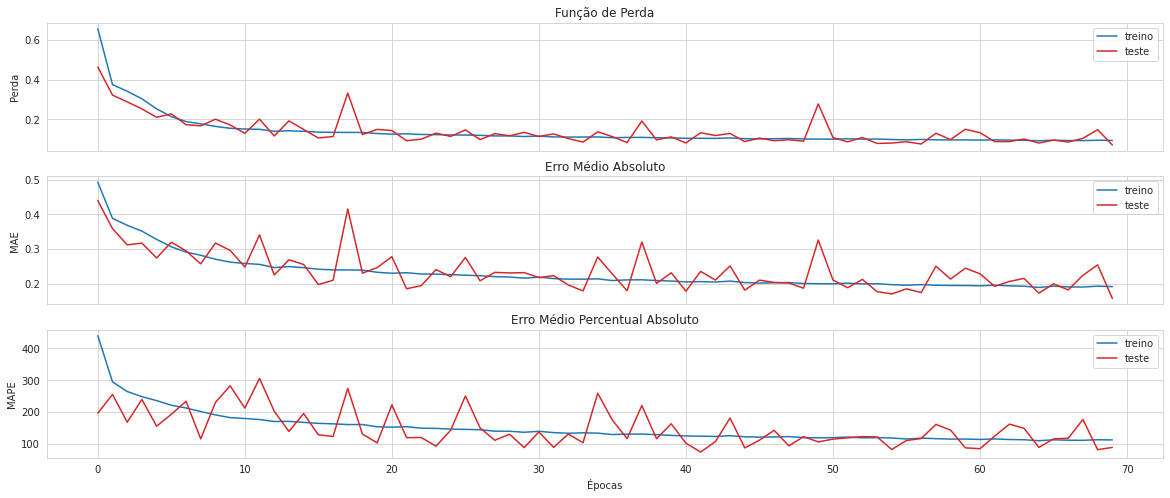

In [15]:
#@title Plot das Métricas do Modelo
# Split variables
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_mae = history.history['MAE']
test_mae = history.history['val_MAE']
train_mape = history.history['MAPE']
test_mape = history.history['val_MAPE']
epoch = range(len(test_mape))

# Create two subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 8))
axs[0].plot(epoch, train_loss, 'tab:blue', label='treino')
axs[0].plot(epoch, test_loss, 'tab:red', label='teste')
axs[0].set_title('Função de Perda')
axs[0].set(ylabel='Perda')
# axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(epoch, train_mae, 'tab:blue', label='treino')
axs[1].plot(epoch, test_mae, 'tab:red', label='teste')
axs[1].set_title('Erro Médio Absoluto')
axs[1].set(ylabel='MAE')
# axs[1].set_ylim([0, 2])
axs[1].legend()

axs[2].plot(epoch, train_mape, 'tab:blue', label='treino')
axs[2].plot(epoch, test_mape, 'tab:red', label='teste')
axs[2].set_title('Erro Médio Percentual Absoluto')
axs[2].set(ylabel='MAPE')
# axs[2].set_ylim([0, 2])
axs[2].legend()

for ax in axs.flat:
    ax.set(xlabel='Épocas')

for ax in axs.flat:
    ax.label_outer()

plt.show()

In [14]:
#@title Salvando o modelo para reutilização
version = '100'
model.save(f"drive/My Drive/Models/model_option_dnn_{version}.h5")

# Gráficos das opções

Para comparação foram escolhidas aleatóriamente 10 opções da base de teste.

In [24]:
#@title Função de comparação
from sklearn.metrics import mean_squared_error

def predict(model, data, options, expire):

    # Select options
    df = data[(data['option'] == options) & (data['expire'] == expire)]

    # Convert to dataset
    ds = df_to_dataset(df, shuffle=False)

    # Predict values
    pred = model.predict(ds)

    rmse_bs = np.sqrt(mean_squared_error(df['value'],df['bs']))
    rmse_dnn = np.sqrt(mean_squared_error(df['value'], pred))
    if rmse_dnn < rmse_bs:
        result = 'Rede Neural'
    else:
        result = 'Black-Scholes'

    fig, axs = plt.subplots(figsize=(20, 4))
    axs.plot(df.index, pred, 'tab:blue', label='DNN')
    axs.plot(df.index, df['bs'], 'tab:green', label='BS')
    axs.plot(df.index, df['value'], 'tab:red', label=options)
    axs.set_title(f'{options} - Black-Scholes:{rmse_bs:.4f}, DNN:{rmse_dnn:.4f}, Melhor modelo {result}')
    axs.set(ylabel='Valor R$')
    axs.set(xlabel='data')
    axs.legend()

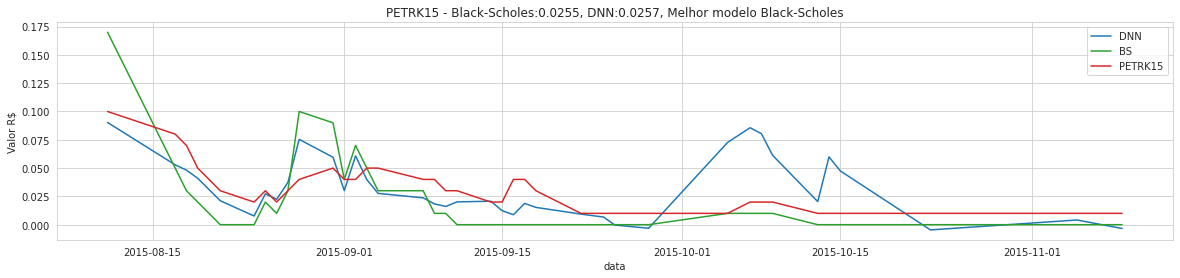

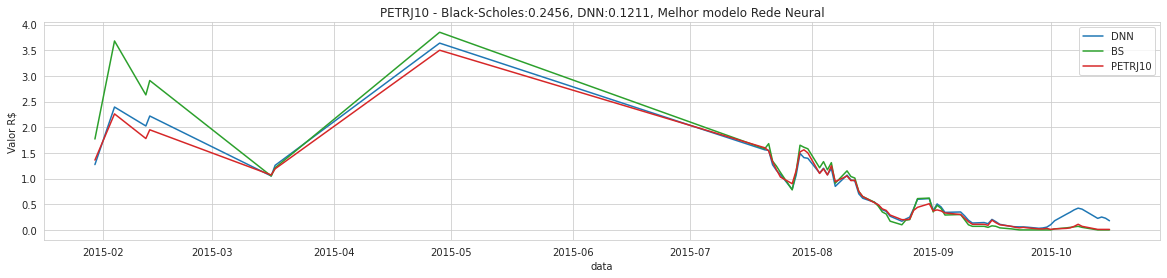

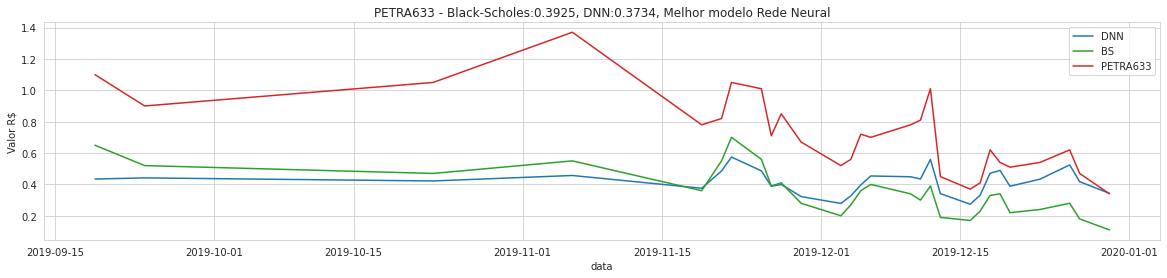

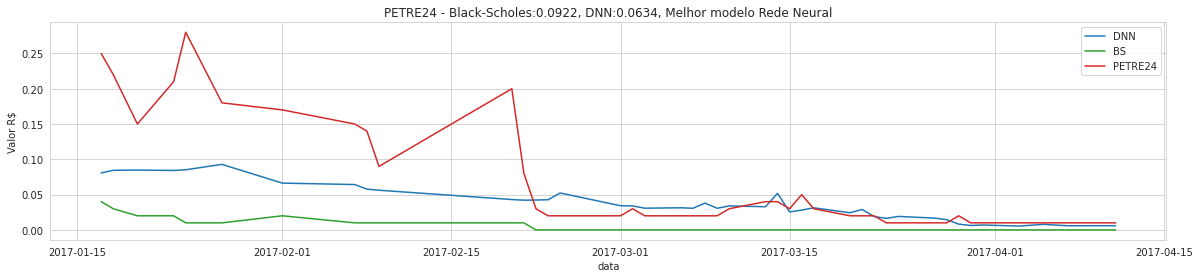

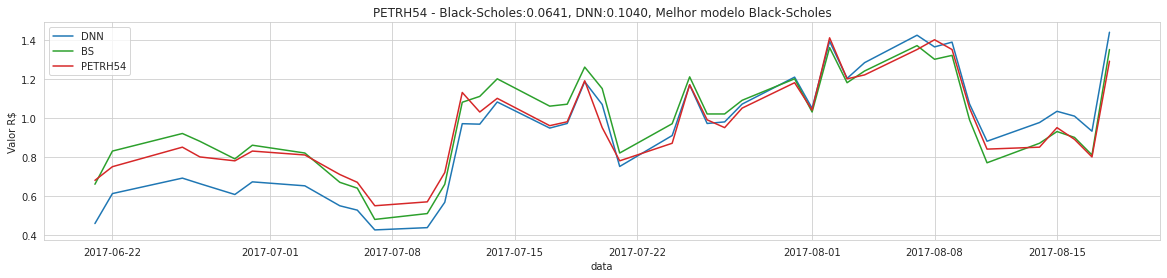

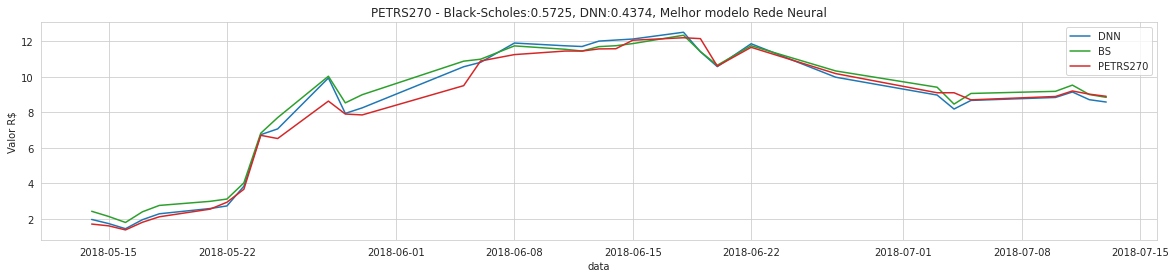

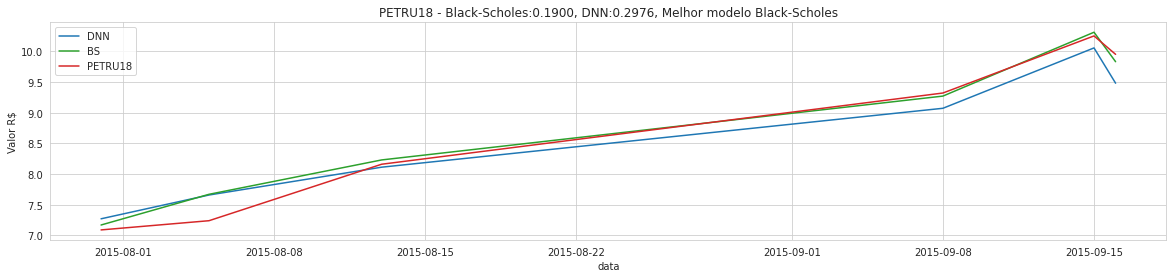

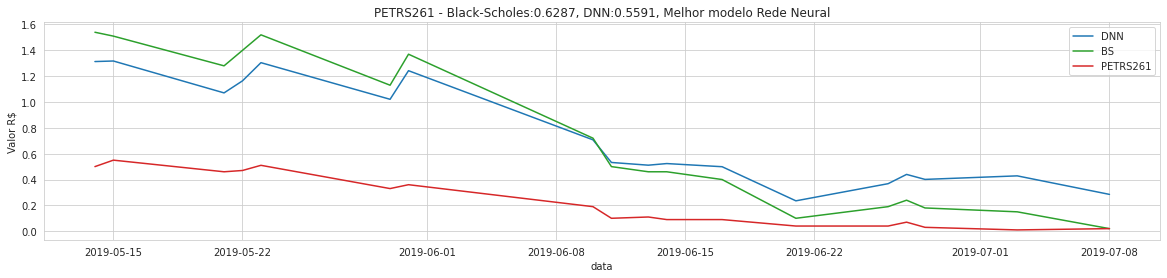

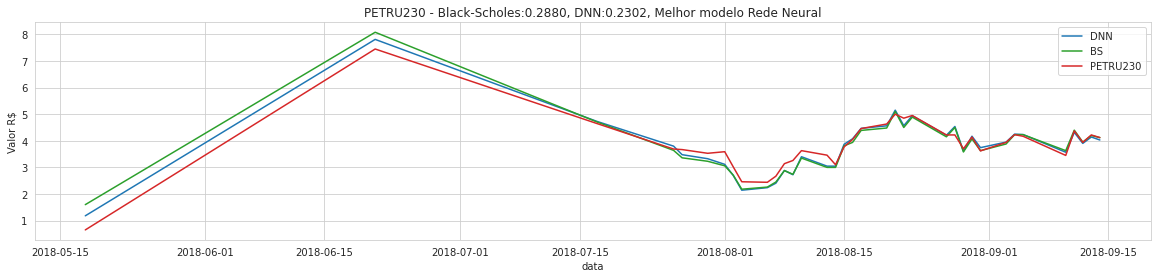

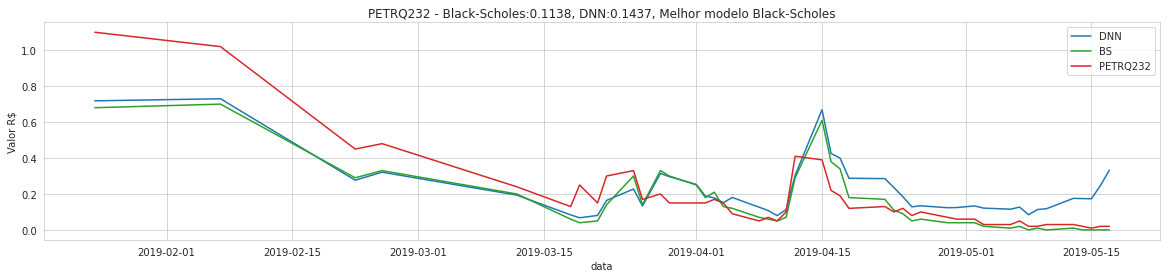

In [25]:
#@title 
for option_type in ['call', 'put']:
    
    options = test.loc[test['option_type'] == option_type, ['option', 'expire']].drop_duplicates()

    for _ in range(5):

        rand = np.random.randint(options.shape[0])

        predict(
            model,
            data,
            options.iloc[rand, 0],
            options.iloc[rand, 1]
        )